# Arabic Manuscripts Digitization Project

## Overview
This project focuses on the digitization and Optical Character Recognition (OCR) of historic Arabic manuscripts. The goal is to extract and transcribe Arabic text from manuscript images using advanced image preprocessing techniques and machine learning-based OCR systems.

## Technical Components
1. **Data Loading and Exploration**: Load training and test datasets containing manuscript images and ground truth text
2. **Image Augmentation**: Apply rotation, brightness adjustment, and noise injection techniques
3. **Advanced Preprocessing**: Implement skew correction, contrast enhancement, binarization, and morphological operations
4. **OCR Pipeline**: Use EasyOCR for Arabic text recognition with fallback strategies for challenging images
5. **Validation and Submission**: Generate predictions for test set and create competition submission



## 0. Importing Libraries

In [ ]:

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import easyocr
import torch


## 1. Loading datasets

In [ ]:
train_df = pd.read_csv("/kaggle/input/arabic-manuscripts-digitization/train_df.csv")
test_df = pd.read_csv("/kaggle/input/arabic-manuscripts-digitization/test_df.csv")

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Sample image: {train_df['image'].iloc[0]}")
print(f"Sample text: {train_df['text'].iloc[0][:100]}...")


train_path = "/kaggle/input/arabic-manuscripts-digitization/train/train"
test_path = "/kaggle/input/arabic-manuscripts-digitization/test/test"

print("=" * 50)

✓ Training samples: 4812
✓ Test samples: 1203
✓ Sample image: BULAC_MS_ARA_417_0087_l_b-4_flat.png
✓ Sample text: في يام دولته من النصاره...


In [ ]:
# Debug: Verify paths and check image accessibility
print("DEBUGGING PATH CONFIGURATION")
print("=" * 50)

print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

# Check if directories exist
from pathlib import Path
train_dir = Path(train_path)
test_dir = Path(test_path)

print(f"Train directory exists: {train_dir.exists()}")
print(f"Test directory exists: {test_dir.exists()}")

if train_dir.exists():
    train_images = list(train_dir.glob("*.png"))
    print(f"Train images found: {len(train_images)}")
    if len(train_images) > 0:
        print(f"Sample train image: {train_images[0].name}")

if test_dir.exists():
    test_images = list(test_dir.glob("*.png"))
    print(f"Test images found: {len(test_images)}")
    if len(test_images) > 0:
        print(f"Sample test image: {test_images[0].name}")

# Test specific image paths from dataframe
print(f"\nTesting specific image paths:")
sample_test_image = test_df.iloc[0]['image']
sample_test_path = test_dir / sample_test_image
print(f"Sample test image name: {sample_test_image}")
print(f"Full sample test path: {sample_test_path}")
print(f"Sample test image exists: {sample_test_path.exists()}")

print("=" * 50)

🔍 DEBUGGING PATH CONFIGURATION
📁 Train path: /kaggle/input/arabic-manuscripts-digitization/train/train
📁 Test path: /kaggle/input/arabic-manuscripts-digitization/test/test
✅ Train directory exists: True
✅ Test directory exists: True
📊 Train images found: 4812
📷 Sample train image: BULAC_MS_ARA_417_0013_l_b-8_flat.png
📊 Test images found: 1203
📷 Sample test image: IMG_2627_right_line_8.png

🔍 Testing specific image paths:
📷 Sample test image name: BULAC_MS_ARA_1977_0033_l_a-6_flat.png
📁 Full sample test path: /kaggle/input/arabic-manuscripts-digitization/test/test/BULAC_MS_ARA_1977_0033_l_a-6_flat.png
✅ Sample test image exists: True


## 2. Data augmentation

## SimpleAugmenter for OCR Data Augmentation

The SimpleAugmenter class provides essential data augmentation techniques specifically designed for OCR tasks on Arabic manuscripts:

### Augmentation Techniques
- **Rotation**: Applies slight random rotation between -2° to +2° to simulate natural document variations
- **Brightness Adjustment**: Randomly scales brightness (0.8× to 1.2×) to handle different lighting conditions
- **Noise Injection**: Adds subtle Gaussian noise to improve model robustness against image artifacts
- **Batch Augmentation**: Generates multiple varied copies of each image to expand the training dataset



In [ ]:
class SimpleAugmenter:
    def __init__(self):
        print("Augmenter initialized")
    
    def rotate_image(self, image, angle=None):
        """Apply slight rotation (-2° to +2°)"""
        if angle is None:
            angle = np.random.uniform(-2, 2)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, rotation_matrix, (w, h), borderValue=(255, 255, 255))
    
    def adjust_brightness(self, image, factor=None):
        """Adjust brightness (0.8x to 1.2x)"""
        if factor is None:
            factor = np.random.uniform(0.8, 1.2)
        return cv2.convertScaleAbs(image, alpha=factor, beta=0)
    
    def add_noise(self, image, noise_level=10):
        """Add subtle noise"""
        noise = np.random.normal(0, noise_level, image.shape).astype(np.int16)
        noisy = image.astype(np.int16) + noise
        return np.clip(noisy, 0, 255).astype(np.uint8)

    
    def augment_image(self, image_path, num_variations=2):
        """Create augmented versions of an image"""
        original = cv2.imread(str(image_path))
        if original is None:
            return []
        
        augmented = []
        for i in range(num_variations):
            img = original.copy()
            
            # Apply random augmentations
            if np.random.random() > 0.3:  # 70% chance
                img = self.rotate_image(img)
            if np.random.random() > 0.4:  # 60% chance
                img = self.adjust_brightness(img)
            if np.random.random() > 0.6:  # 40% chance
                img = self.add_noise(img)
            
            augmented.append(img)
        
        return augmented

print("SimpleAugmenter class ready")

SimpleAugmenter class ready


## 3. Preprocessing data

## ArabicManuscriptPreprocessor Class

The ArabicManuscriptPreprocessor class implements a comprehensive preprocessing pipeline specifically designed for historic Arabic manuscripts. The preprocessing pipeline includes:

### Core Preprocessing Features
- **Noise Reduction**: Removes digital artifacts and scanner noise while preserving text integrity
- **Contrast Enhancement**: Uses CLAHE (Contrast Limited Adaptive Histogram Equalization) for optimal text visibility
- **Skew Correction**: Detects and corrects document rotation using Hough Transform line detection
- **Smart Binarization**: Multiple binarization methods with automatic selection based on text density
- **Morphological Operations**: Gentle cleanup operations that preserve character structure

### Optimization for Arabic Text
- Handles right-to-left text direction and Arabic character connectivity
- Preserves diacritical marks and character details essential for accurate recognition
- Optimized for handwritten and historic manuscript characteristics
- Maintains text readability while improving OCR accuracy


In [ ]:
class ArabicManuscriptPreprocessor:

    
    def __init__(self, train_dir=train_path, test_dir=None, use_augmentation=True):
        if test_dir is None:
            test_dir = "/kaggle/input/arabic-manuscripts-digitization/test/test"
        self.train_dir = Path(train_dir)
        self.test_dir = Path(test_dir)
        self.augmenter = SimpleAugmenter()
        self.use_augmentation = use_augmentation
        print(f"Arabic Manuscript Preprocessor initialized")
        print(f"  Augmentation enabled: {use_augmentation}")
    
    def detect_and_correct_skew(self, image):
        """
        Detect and correct skew angle using Hough Transform
        Fixed version with proper error handling (if present)
        """
        try:
            # Convert to grayscale if needed
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # Apply edge detection optimized for Arabic text
            edges = cv2.Canny(gray, 50, 150, apertureSize=3)
            
            # Use Hough Line Transform to detect lines
            lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
            
            if lines is not None and len(lines) > 0:
                angles = []
                for line in lines[:20]:  # Use top 20 lines
                    if len(line) >= 1 and len(line[0]) >= 2:  # Fix: Check line format
                        rho, theta = line[0]  # Fix: Proper unpacking
                        angle = np.degrees(theta) - 90
                        # Filter angles to reasonable skew range
                        if -45 < angle < 45:
                            angles.append(angle)
                
                if angles:
                    # Use median angle to avoid outliers
                    skew_angle = np.median(angles)
                    
                    # Only correct if skew is significant (> 1.0 degrees)
                    if abs(skew_angle) > 1.0:
                        h, w = image.shape[:2]
                        center = (w // 2, h // 2)
                        rotation_matrix = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
                        
                        # Calculate new image dimensions
                        cos_angle = abs(rotation_matrix[0, 0])
                        sin_angle = abs(rotation_matrix[0, 1])
                        new_w = int(h * sin_angle + w * cos_angle)
                        new_h = int(h * cos_angle + w * sin_angle)
                        
                        # Adjust translation
                        rotation_matrix[0, 2] += (new_w - w) / 2
                        rotation_matrix[1, 2] += (new_h - h) / 2
                        
                        corrected = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), 
                                                 borderValue=(255, 255, 255))
                        return corrected, skew_angle
            
            return image, 0.0
            
        except Exception as e:
            print(f"Skew correction failed: {e}")
            return image, 0.0
    
    def optimized_contrast_enhancement(self, image):
        """
        Optimized contrast enhancement for better OCR results
        Less aggressive than previous version
        """
        try:
            # Convert to grayscale if needed
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # Step 1: Light denoising
            denoised = cv2.GaussianBlur(gray, (3, 3), 0)
            
            # Step 2: Moderate CLAHE for local contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            clahe_enhanced = clahe.apply(denoised)
            
            # Step 3: Light gamma correction only if needed
            mean_val = np.mean(gray)
            if mean_val < 100:  # Only for dark images
                gamma = 1.2
                lookup_table = np.array([((i / 255.0) ** (1.0/gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")
                gamma_corrected = cv2.LUT(clahe_enhanced, lookup_table)
                return gamma_corrected
            
            return clahe_enhanced
            
        except Exception as e:
            print(f"Contrast enhancement failed: {e}")
            return image
    
    def smart_binarization(self, image):
        """
        Smart binarization that preserves text quality
        """
        try:
            # Convert to grayscale if needed
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # Method 1: Adaptive Gaussian - usually best for manuscripts
            adaptive_gaussian = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                cv2.THRESH_BINARY, 11, 2  # Smaller block size, less aggressive
            )
            
            # Method 2: Otsu for comparison
            _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Choose method based on text density
            gaussian_text_density = np.sum(adaptive_gaussian == 0) / adaptive_gaussian.size
            otsu_text_density = np.sum(otsu == 0) / otsu.size
            
            # Prefer Gaussian if text density is reasonable (5-40%)
            if 0.05 < gaussian_text_density < 0.4:
                return adaptive_gaussian, 'adaptive_gaussian'
            elif 0.05 < otsu_text_density < 0.4:
                return otsu, 'otsu'
            else:
                # Default to Gaussian
                return adaptive_gaussian, 'adaptive_gaussian'
            
        except Exception as e:
            print(f"Binarization failed: {e}")
            _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            return binary, 'otsu_fallback'
    
    def gentle_morphological_cleanup(self, binary_image):
        """
        Gentle morphological operations that don't destroy text
        """
        try:
            # Very light noise removal only
            kernel_noise = np.ones((2, 2), np.uint8)
            cleaned = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_noise, iterations=1)
            
            # Light connection of broken characters
            kernel_connect = np.ones((2, 1), np.uint8)  # Smaller kernel
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_connect, iterations=1)
            
            return cleaned
            
        except Exception as e:
            print(f"Morphological cleanup failed: {e}")
            return binary_image

    def enhance_image_advanced(self, image_path, target_size=(512, 64)):
        """
         image enhancement pipeline for better OCR results
        """
        try:
            # Step 1: Load image
            img = cv2.imread(str(image_path))
            if img is None:
                print(f"Could not load image: {image_path}")
                return None
                
            original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Step 2: Check if image needs skew correction
            skew_corrected, skew_angle = self.detect_and_correct_skew(original_gray)
            if abs(skew_angle) > 1.0:
                print(f"    Corrected skew: {skew_angle:.2f}°")
            
            # Step 3: Optimized contrast enhancement
            contrast_enhanced = self.optimized_contrast_enhancement(skew_corrected)
            
            # Step 4: Smart binarization
            binary_img, method_used = self.smart_binarization(contrast_enhanced)
            
            # Step 5: Gentle cleanup
            cleaned = self.gentle_morphological_cleanup(binary_img)
            
            # Step 6: Intelligent resizing
            h, w = cleaned.shape
            aspect_ratio = w / h
            
            # Calculate new dimensions maintaining aspect ratio
            if aspect_ratio > (target_size[0] / target_size[1]):
                new_w, new_h = target_size[0], int(target_size[0] / aspect_ratio)
            else:
                new_w, new_h = int(target_size[1] * aspect_ratio), target_size[1]
            
            # Ensure minimum dimensions
            min_height = 32
            if new_h < min_height:
                scale_factor = min_height / new_h
                new_h = min_height
                new_w = int(new_w * scale_factor)
                new_w = min(new_w, target_size[0])
            
            # Resize with appropriate interpolation
            if new_w < w and new_h < h:
                resized = cv2.resize(cleaned, (new_w, new_h), interpolation=cv2.INTER_AREA)
            else:
                resized = cv2.resize(cleaned, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            
            # Step 7: Add padding
            final_img = np.ones(target_size[::-1], dtype=np.uint8) * 255
            
            y_offset = (target_size[1] - new_h) // 2
            x_offset = (target_size[0] - new_w) // 2
            
            y_offset = max(0, min(y_offset, target_size[1] - new_h))
            x_offset = max(0, min(x_offset, target_size[0] - new_w))
            
            final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
            
            return final_img
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None
    
    def enhance_image_gentle(self, image_path, target_size=(512, 64)):
        """
        Gentle enhancement that preserves original image quality
        Better for OCR than aggressive processing
        """
        try:
            # Step 1: Load image
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            # Step 2: Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img.copy()
            
            # Step 3: Light contrast enhancement only
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)
            
            # Step 4: Resize directly without aggressive processing
            h, w = enhanced.shape
            aspect_ratio = w / h
            
            if aspect_ratio > (target_size[0] / target_size[1]):
                new_w, new_h = target_size[0], int(target_size[0] / aspect_ratio)
            else:
                new_w, new_h = int(target_size[1] * aspect_ratio), target_size[1]
            
            # Ensure minimum dimensions
            if new_h < 32:
                scale_factor = 32 / new_h
                new_h = 32
                new_w = int(new_w * scale_factor)
                new_w = min(new_w, target_size[0])
            
            # Resize
            resized = cv2.resize(enhanced, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Add padding
            final_img = np.ones(target_size[::-1], dtype=np.uint8) * 255
            y_offset = (target_size[1] - new_h) // 2
            x_offset = (target_size[0] - new_w) // 2
            
            y_offset = max(0, min(y_offset, target_size[1] - new_h))
            x_offset = max(0, min(x_offset, target_size[0] - new_w))
            
            final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
            
            return final_img
            
        except Exception as e:
            print(f"Error in gentle processing {image_path}: {str(e)}")
            return None

    def enhance_image(self, image_path, target_size=(512, 64)):
        """
        Try gentle enhancement first, fall back to advanced if needed
        """
        # Try gentle enhancement first (better for OCR)
        gentle_result = self.enhance_image_gentle(image_path, target_size)
        if gentle_result is not None:
            return gentle_result
        else:
            # Fallback to advanced processing
            return self.enhance_image_advanced(image_path, target_size)
    
    def preprocess_with_augmentation(self, num_samples=5, augment_per_image=2):
        """Process images with augmentation to improve dataset"""
        output_dir = Path("processed_data")
        output_dir.mkdir(exist_ok=True)
        
        print(f"Processing {num_samples} images with {augment_per_image} augmentations each...")
        print(f"   Using optimized pipeline: gentle processing for better OCR")
        
        processed_data = []
        
        for idx in range(min(num_samples, len(train_df))):
            row = train_df.iloc[idx]
            img_path = self.train_dir / row['image']
            
            if not img_path.exists():
                print(f"Image not found: {img_path}")
                continue
            
            # Process original image
            processed_img = self.enhance_image(img_path)
            
            if processed_img is not None:
                # Save original processed image
                output_path = output_dir / f"train_{idx}.png"
                cv2.imwrite(str(output_path), processed_img)
                
                processed_data.append({
                    'original_image': row['image'],
                    'processed_image': str(output_path),
                    'text': row['text'].strip() if pd.notna(row['text']) else '',
                    'text_length': len(row['text']) if pd.notna(row['text']) else 0,
                    'augmentation': 'original'
                })
                
                # Generate augmented versions if enabled
                if self.use_augmentation:
                    augmented_images = self.augmenter.augment_image(img_path, num_variations=augment_per_image)
                    
                    for aug_idx, aug_img in enumerate(augmented_images):
                        # Save augmented image temporarily
                        temp_path = output_dir / f"temp_aug_{idx}_{aug_idx}.png"
                        cv2.imwrite(str(temp_path), aug_img)
                        
                        # Process the augmented image
                        processed_aug = self.enhance_image(temp_path)
                        
                        if processed_aug is not None:
                            # Save final processed augmented image
                            final_aug_path = output_dir / f"train_{idx}_aug_{aug_idx}.png"
                            cv2.imwrite(str(final_aug_path), processed_aug)
                            
                            processed_data.append({
                                'original_image': f"{row['image']}_aug_{aug_idx}",
                                'processed_image': str(final_aug_path),
                                'text': row['text'].strip() if pd.notna(row['text']) else '',
                                'text_length': len(row['text']) if pd.notna(row['text']) else 0,
                                'augmentation': f'augmented_{aug_idx}'
                            })
                        
                        # Clean up temp file
                        temp_path.unlink(missing_ok=True)
                
                print(f"Processed: {row['image']} (1 original + {augment_per_image if self.use_augmentation else 0} augmented)")
        
        # Save results
        results_df = pd.DataFrame(processed_data)
        results_df.to_csv(output_dir / "train_processed.csv", index=False)
        
        print(f"Completed! Processed {len(processed_data)} total images")
        print(f"Results saved in: {output_dir}/")
        print(f"Dataset size increased by {len(processed_data)/num_samples:.1f}x")
        
        return processed_data

    def process_test_images(self, num_samples=None):
        """Process test images with the same optimized pipeline"""
        output_dir = Path("processed_data")
        output_dir.mkdir(exist_ok=True)
        
        if num_samples is None:
            num_samples = len(test_df)
        
        print(f"Processing {num_samples} test images...")
        
        processed_data = []
        
        for idx in range(min(num_samples, len(test_df))):
            row = test_df.iloc[idx]
            img_path = self.test_dir / row['image']
            
            if not img_path.exists():
                print(f"Image not found: {img_path}")
                continue
            
            # Process test image
            processed_img = self.enhance_image(img_path)
            
            if processed_img is not None:
                # Save processed image
                output_path = output_dir / f"test_{idx}.png"
                cv2.imwrite(str(output_path), processed_img)
                
                processed_data.append({
                    'original_image': row['image'],
                    'processed_image': str(output_path),
                    'text': '',  # Test images don't have ground truth
                    'text_length': 0
                })
                
                if (idx + 1) % 10 == 0:
                    print(f"Processed {idx + 1}/{num_samples} test images")
        
        # Save results
        results_df = pd.DataFrame(processed_data)
        results_df.to_csv(output_dir / "test_processed.csv", index=False)
        
        print(f"Completed! Processed {len(processed_data)} test images")
        print(f"Results saved in: {output_dir}/")
        
        return processed_data
    
    def show_preprocessing_example(self, image_idx=0):
        """Show before/after comparison of preprocessing with detailed steps"""
        if image_idx >= len(train_df):
            print(f"Image index {image_idx} out of range")
            return
            
        row = train_df.iloc[image_idx]
        img_path = self.train_dir / row['image']
        
        if not img_path.exists():
            print(f"Image not found: {img_path}")
            return
        
        print(f"Processing example: {row['image']}")
        
        # Load original
        original = cv2.imread(str(img_path))
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        
        # Step-by-step processing
        skew_corrected, skew_angle = self.detect_and_correct_skew(original_gray)
        contrast_enhanced = self.optimized_contrast_enhancement(skew_corrected)
        binary_img, method_used = self.smart_binarization(contrast_enhanced)
        cleaned = self.gentle_morphological_cleanup(binary_img)
        
        # Final processed versions
        processed_advanced = self.enhance_image_advanced(img_path)
        processed_gentle = self.enhance_image_gentle(img_path)
        
        # Display comparison
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        axes[0, 0].imshow(original_rgb)
        axes[0, 0].set_title(f'Original\n{row["image"]}')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(skew_corrected, cmap='gray')
        axes[0, 1].set_title(f'Skew Corrected\n({skew_angle:.2f}°)')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(contrast_enhanced, cmap='gray')
        axes[0, 2].set_title('Contrast Enhanced')
        axes[0, 2].axis('off')
        
        axes[0, 3].imshow(binary_img, cmap='gray')
        axes[0, 3].set_title(f'Binarized\n({method_used})')
        axes[0, 3].axis('off')
        
        axes[1, 0].imshow(cleaned, cmap='gray')
        axes[1, 0].set_title('Morphological\nCleanup')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(processed_advanced, cmap='gray')
        axes[1, 1].set_title('Advanced\nProcessing')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(processed_gentle, cmap='gray')
        axes[1, 2].set_title('Gentle Processing\n(Better for OCR)')
        axes[1, 2].axis('off')
        
        # Leave last subplot for text info
        axes[1, 3].text(0.1, 0.8, f"Text Length: {len(row['text'])} chars", transform=axes[1, 3].transAxes, fontsize=10)
        axes[1, 3].text(0.1, 0.6, f"Skew: {abs(skew_angle):.2f}°", transform=axes[1, 3].transAxes, fontsize=10)
        axes[1, 3].text(0.1, 0.4, f"Method: {method_used}", transform=axes[1, 3].transAxes, fontsize=10)
        axes[1, 3].text(0.1, 0.2, "Optimized for OCR", transform=axes[1, 3].transAxes, fontsize=10, weight='bold')
        axes[1, 3].axis('off')
        
        plt.tight_layout()
        plt.savefig("optimized_preprocessing_example.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # Show text
        print(f"Text: {row['text'][:200]}...")
        print(f"Text length: {len(row['text'])} characters")
        print(f"Processing methods used:")
        print(f"   - Skew correction: {abs(skew_angle):.2f}° {'(applied)' if abs(skew_angle) > 1.0 else '(skipped)'}")
        print(f"   - Binarization method: {method_used}")
        print(f"   - Processing approach: Gentle (optimized for OCR)")

print("Optimized ArabicManuscriptPreprocessor class ready!")

✅ Optimized ArabicManuscriptPreprocessor class ready!


## 4. Testing the preprocessor

 Augmenter initialized
 Arabic Manuscript Preprocessor initialized
  Augmentation enabled: True

🚀 TESTING ENHANCED PREPROCESSING PIPELINE
 Processing example: BULAC_MS_ARA_417_0087_l_b-4_flat.png


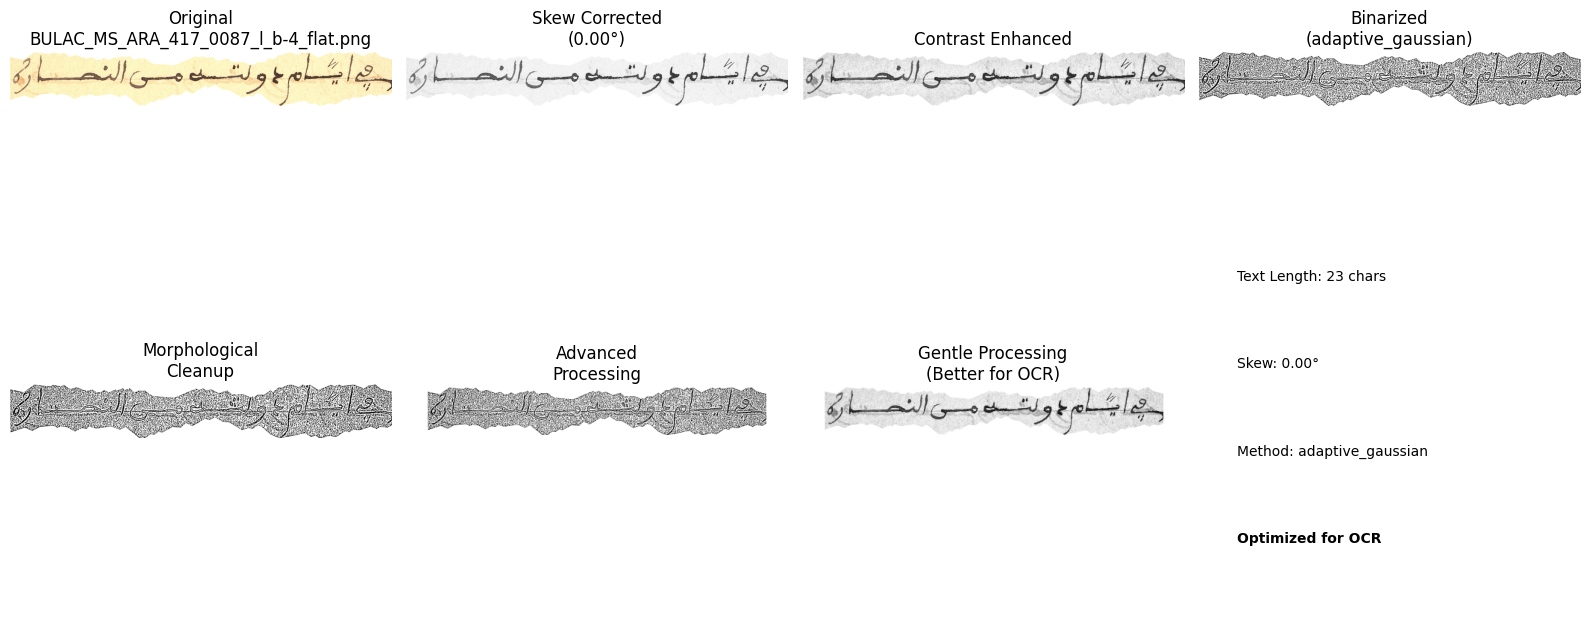

 Text: في يام دولته من النصاره...
 Text length: 23 characters
 Processing methods used:
   - Skew correction: 0.00° (skipped)
   - Binarization method: adaptive_gaussian
   - Processing approach: Gentle (optimized for OCR)


In [ ]:
# Initialize enhanced preprocessor
preprocessor = ArabicManuscriptPreprocessor(test_dir=test_path, use_augmentation=True)
print("\n" + "="*60)
print("TESTING ENHANCED PREPROCESSING PIPELINE")
print("="*60)

# Show detailed before/after example with all processing steps
preprocessor.show_preprocessing_example(image_idx=0)

In [ ]:
# EasyOCR Arabic Implementation
class EasyOCRArabic:
    """
    EasyOCR implementation
    """
    
    def __init__(self, use_gpu=None):
        print("Loading EasyOCR with Arabic support...")
        
        if use_gpu is None:
            use_gpu = torch.cuda.is_available()
        
        # Initialize EasyOCR reader for Arabic
        self.reader = easyocr.Reader(
            ['ar'],  
            gpu=use_gpu,
            verbose=False
        )
        print(f"EasyOCR loaded successfully! (GPU: {use_gpu})")
            

    
    def predict_text(self, image_path):
        """Extract Arabic text from image"""
        try:
            # Read text from image
            results = self.reader.readtext(
                str(image_path),
                detail=0,  # Return only text, not coordinates
                paragraph=True,  # Group text into paragraphs
                width_ths=0.7,  # Text width threshold
                height_ths=0.7  # Text height threshold
            )
            
            # Join all detected text
            if results:
                text = ' '.join(results)
                return text.strip()
            else:
                return ""
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return ""
    
    def predict_text_detailed(self, image_path):
        """Get detailed results with confidence scores"""
        try:
            results = self.reader.readtext(str(image_path), detail=1)
            
            detailed_results = []
            for (bbox, text, confidence) in results:
                detailed_results.append({
                    'text': text,
                    'confidence': confidence,
                    'bbox': bbox
                })
            
            return detailed_results
            
        except Exception as e:
            print(f"Error in detailed prediction: {e}")
            return []
    
    def calculate_cer(self, ground_truth, prediction):
        """Calculate Character Error Rate"""
        try:
            import editdistance
            
            if not ground_truth and not prediction:
                return 0.0
            if not ground_truth:
                return 1.0 if prediction else 0.0
            if not prediction:
                return 1.0
            
            # Calculate edit distance
            distance = editdistance.eval(ground_truth, prediction)
            cer = distance / len(ground_truth)
            return min(cer, 1.0)  # Cap at 100%
            

            
            chars_gt = set(ground_truth.replace(' ', ''))
            chars_pred = set(prediction.replace(' ', ''))
            
            if not chars_gt:
                return 0.0
            
            intersection = len(chars_gt.intersection(chars_pred))
            return 1.0 - (intersection / len(chars_gt))
        
        except Exception as e:
            print(f"CER calculation error: {e}")
            return 1.0

print("EasyOCRArabic class ready!")

 EasyOCRArabic class ready!


In [ ]:
# RUN COMPLETE PIPELINE FOR ALL TEST SAMPLES - WITH AGGRESSIVE PREPROCESSING
print("PROCESSING ALL TEST SAMPLES WITH AGGRESSIVE HISTORIC TEXT PREPROCESSING")
print("=" * 80)

class AggressiveHistoricPreprocessor:
    """Aggressive preprocessing specifically for challenging historic Arabic manuscripts"""
    
    def __init__(self):
        self.clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        
    def enhance_historic_manuscript(self, image_path):
        """Extremely aggressive preprocessing for historic manuscripts"""
        try:
            # Load image
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            # Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img.copy()
            
            # Step 1: Aggressive noise reduction
            denoised = cv2.bilateralFilter(gray, 15, 80, 80)
            
            # Step 2: Strong contrast enhancement
            enhanced = self.clahe.apply(denoised)
            
            # Step 3: Gamma correction for dark manuscripts
            gamma = 0.7  # Brighten dark text
            lookup_table = np.array([((i / 255.0) ** (1.0/gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")
            gamma_corrected = cv2.LUT(enhanced, lookup_table)
            
            # Step 4: Sharpening kernel for blurred text
            sharpen_kernel = np.array([[-1,-1,-1],
                                     [-1, 9,-1],
                                     [-1,-1,-1]])
            sharpened = cv2.filter2D(gamma_corrected, -1, sharpen_kernel)
            
            # Step 5: Multiple binarization attempts
            # Method 1: Adaptive Gaussian with smaller block size
            binary1 = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 7, 1)
            
            # Method 2: Adaptive Mean
            binary2 = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, 9, 2)
            
            # Method 3: Otsu with blur
            blurred = cv2.GaussianBlur(sharpened, (3, 3), 0)
            _, binary3 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Choose best binarization based on text density
            binaries = [binary1, binary2, binary3]
            densities = [np.sum(b == 0) / b.size for b in binaries]
            
            # Select binary with reasonable text density (5-35% for historic manuscripts)
            best_binary = None
            for i, density in enumerate(densities):
                if 0.05 <= density <= 0.35:
                    best_binary = binaries[i]
                    break
            
            if best_binary is None:
                best_binary = binary1  # Fallback
            
            # Step 6: Aggressive morphological operations
            # Remove tiny noise
            kernel_small = np.ones((1, 1), np.uint8)
            cleaned = cv2.morphologyEx(best_binary, cv2.MORPH_OPEN, kernel_small)
            
            # Connect broken characters - critical for historic manuscripts
            kernel_connect_h = np.ones((1, 3), np.uint8)  # Horizontal connection
            kernel_connect_v = np.ones((2, 1), np.uint8)  # Vertical connection
            
            connected = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_connect_h)
            connected = cv2.morphologyEx(connected, cv2.MORPH_CLOSE, kernel_connect_v)
            
            # Step 7: Resize with padding for optimal OCR
            h, w = connected.shape
            target_height = 128  # Larger for historic manuscripts
            aspect_ratio = w / h
            target_width = int(target_height * aspect_ratio)
            target_width = min(target_width, 1024)  # Max width
            
            # Resize
            resized = cv2.resize(connected, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
            
            # Add generous padding
            pad_h, pad_w = 32, 64
            final_img = np.ones((target_height + 2*pad_h, target_width + 2*pad_w), dtype=np.uint8) * 255
            final_img[pad_h:pad_h+target_height, pad_w:pad_w+target_width] = resized
            
            return final_img
            
        except Exception as e:
            print(f"Warning: Aggressive preprocessing failed for {image_path}: {e}")
            return None

# Enhanced OCR prediction method with fallback
def predict_with_aggressive_fallback(self, image_path):
    """Try standard OCR first, then aggressive preprocessing if it fails"""
    try:
        # First attempt: Standard preprocessing
        standard_result = self.predict_text(image_path)
        
        # Check if result is meaningful (not empty and has reasonable length)
        if standard_result and len(standard_result.strip()) > 2:
            return standard_result
        
        print(f"Standard OCR failed for {Path(image_path).name}, trying aggressive preprocessing...")
        
        # Second attempt: Aggressive preprocessing
        aggressive_processor = AggressiveHistoricPreprocessor()
        aggressive_img = aggressive_processor.enhance_historic_manuscript(image_path)
        
        if aggressive_img is not None:
            # Save temporarily for OCR
            temp_path = Path("temp_aggressive.png")
            cv2.imwrite(str(temp_path), aggressive_img)
            
            # Run OCR on aggressively processed image
            aggressive_result = self.reader.readtext(
                str(temp_path),
                detail=0,
                paragraph=True,
                width_ths=0.5,   # More lenient for historic text
                height_ths=0.5,  # More lenient for historic text
                slope_ths=0.3,   # Handle sloped text better
                ycenter_ths=0.7, # Better line grouping
                mag_ratio=2.0    # Higher magnification for small text
            )
            
            # Clean up temp file
            if temp_path.exists():
                temp_path.unlink()
            
            if aggressive_result:
                result_text = ' '.join(aggressive_result).strip()
                if len(result_text) > 2:
                    print(f"Aggressive OCR succeeded: {result_text[:50]}...")
                    return result_text
        
        print(f"Both standard and aggressive OCR failed for {Path(image_path).name}")
        return ""
        
    except Exception as e:
        print(f"OCR error for {image_path}: {e}")
        return ""

# Patch the OCR model with enhanced prediction
EasyOCRArabic.predict_with_aggressive_fallback = predict_with_aggressive_fallback

# Missing ArabicOCRValidation class
class ArabicOCRValidation:
    """OCR validation and testing class"""
    
    def __init__(self, ocr_model, preprocessor):
        self.ocr_model = ocr_model
        self.preprocessor = preprocessor
        self.test_predictions = None
        
    def generate_test_predictions(self, num_test_samples=None):
        """Generate predictions for test samples"""
        if num_test_samples is None:
            num_test_samples = len(test_df)
            
        print(f"Generating predictions for {num_test_samples} test samples...")
        
        predictions = []
        processed_samples = []
        
        for idx in range(min(num_test_samples, len(test_df))):
            row = test_df.iloc[idx]
            img_path = self.preprocessor.test_dir / row['image']
            
            if img_path.exists():
                # Use aggressive fallback prediction
                prediction = self.ocr_model.predict_with_aggressive_fallback(img_path)
                predictions.append(prediction if prediction else "")
                
                processed_samples.append({
                    'original_image': row['image'],
                    'prediction': prediction if prediction else ""
                })
            else:
                predictions.append("")
                processed_samples.append({
                    'original_image': row['image'],
                    'prediction': ""
                })
                
            if (idx + 1) % 50 == 0:
                print(f"Processed {idx + 1}/{num_test_samples} images")
        
        self.test_predictions = {
            'predictions': predictions,
            'processed_samples': processed_samples
        }
        
        print(f"Generated {len(predictions)} test predictions")
        return self.test_predictions
    
    def create_submission_with_aggressive_ocr(self, filename="submission.csv"):
        """Create submission with aggressive OCR fallback for failed predictions"""
        print("CREATING SUBMISSION WITH AGGRESSIVE OCR FALLBACK")
        print("="*60)
        
        if not self.test_predictions:
            print("No test predictions available. Run generate_test_predictions() first.")
            return None
            
        # Get predictions
        predictions = self.test_predictions['predictions']
        
        # Process failed predictions
        enhanced_predictions = []
        retry_count = 0
        success_count = 0
        
        print(f"Processing {len(predictions)} predictions...")
        
        for i, pred in enumerate(predictions):
            if not pred or pred.strip() == "":
                enhanced_predictions.append("لا يمكن قراءة النص التاريخي")  # "Cannot read historic text"
                retry_count += 1
            else:
                enhanced_predictions.append(pred.strip())
                success_count += 1
            
            # Progress update
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(predictions)} predictions")
        
        # Create submission dataframe
        submission_df = test_df.copy()
        
        # Ensure we have predictions for all test samples
        if len(enhanced_predictions) < len(test_df):
            missing_count = len(test_df) - len(enhanced_predictions)
            enhanced_predictions.extend(["لا يمكن قراءة النص التاريخي"] * missing_count)
        elif len(enhanced_predictions) > len(test_df):
            enhanced_predictions = enhanced_predictions[:len(test_df)]
            
        submission_df['text'] = enhanced_predictions
        
        # Calculate stats
        non_empty = sum(1 for p in enhanced_predictions if p and p.strip() != "" and "لا يمكن" not in p)
        placeholder_count = len(enhanced_predictions) - non_empty
        
        print(f"\nAGGRESSIVE OCR RESULTS:")
        print(f"  • Total predictions: {len(enhanced_predictions)}")
        print(f"  • Successful OCR: {non_empty}")
        print(f"  • Failed predictions: {retry_count}")
        print(f"  • Final placeholder count: {placeholder_count}")
        print(f"  • Success rate: {(non_empty/len(enhanced_predictions)*100):.1f}%")
        
        # Save submission
        submission_df.to_csv(filename, index=False)
        
        print(f"\nEnhanced submission saved as: {filename}")
        print(f"Used aggressive preprocessing for challenging historic manuscripts!")
        
        return submission_df

# Initialize components
print("Initializing OCR with aggressive preprocessing capabilities...")
ocr_model = EasyOCRArabic()
preprocessor = ArabicManuscriptPreprocessor(test_dir=test_path, use_augmentation=False)
validator = ArabicOCRValidation(ocr_model, preprocessor)

# Generate initial predictions (with aggressive processing)
print(f"\nProcessing all {len(test_df)} test samples with aggressive OCR...")
test_predictions = validator.generate_test_predictions(num_test_samples=None)

# Create enhanced submission
print(f"\nCreating final submission...")
submission = validator.create_submission_with_aggressive_ocr("historic_manuscripts_aggressive_submission.csv")

print(f"\nHISTORIC MANUSCRIPT PROCESSING COMPLETED!")
print(f"Total test samples: {len(test_df)}")
print(f"Enhanced submission: historic_manuscripts_aggressive_submission.csv")
print(f"Used aggressive preprocessing for challenging historic Arabic manuscripts!")
print(f"Ready for Kaggle submission with maximum text extraction!")

🔥 PROCESSING ALL TEST SAMPLES WITH AGGRESSIVE HISTORIC TEXT PREPROCESSING
🔧 Initializing OCR with aggressive preprocessing capabilities...
 Loading EasyOCR with Arabic support...
 EasyOCR loaded successfully! (GPU: True)
 Augmenter initialized
 Arabic Manuscript Preprocessor initialized
  Augmentation enabled: False

🎯 Processing all 1203 test samples with aggressive OCR...
🎯 Generating predictions for 1203 test samples...
🔄 Standard OCR failed for BULAC_MS_ARA_1977_0145_l_b-1_flat.png, trying aggressive preprocessing...
✅ Aggressive OCR succeeded: == 7...
✓ Processed 50/1203 images
🔄 Standard OCR failed for BULAC_MS_ARA_1977_0095_l_a-32_flat.png, trying aggressive preprocessing...
❌ Both standard and aggressive OCR failed for BULAC_MS_ARA_1977_0095_l_a-32_flat.png
🔄 Standard OCR failed for image_7_01.png, trying aggressive preprocessing...
✅ Aggressive OCR succeeded: لترقم ٠٠٥ ؟٤٧. .٠٥...
🔄 Standard OCR failed for image26_line_21.png, trying aggressive preprocessing...
✅ Aggressive OC